In [11]:
import h5py
import numpy as np
import pickle
import plotly.graph_objects as go
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

In [12]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

In [13]:
pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

In [14]:
##5000*100
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [15]:
Used_feature_group = [pge_pca_feature,resnet50_pca_feature,inceptionv3_pca_feature,vgg16_pca_feature,pge_umap_feature,resnet50_umap_feature,inceptionv3_umap_feature,vgg16_umap_feature]
Used_content_group = [pge_content,resnet50_content,inceptionv3_content,vgg16_content,vgg16_content,pge_content,resnet50_content,inceptionv3_content,vgg16_content,vgg16_content]
N_clusters_group = [x for x in range(3,23,1)]
Silhouette_group = []
V_measure_group = []

/home/alex/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning: plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.

  warnings.warn(
/home/alex/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning: plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene

  warnings.warn(
/home/alex/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/home/alex/anaconda3/

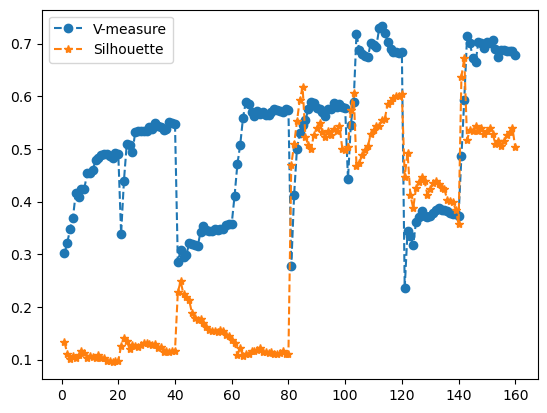

"\n#Visualise tissue type percentage in two different clustering configurations\ndef calculate_percent(sub_df, attrib):\n    cnt = sub_df[attrib].count()\n    output_sub_df = sub_df.groupby(attrib).count()\n    return (output_sub_df/cnt)\n\n\nresulted_cluster_df = pd.DataFrame({'clusterID': HC_assignment, 'type': test_label})\nlabel_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()\npivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')\n\nf, axes = plt.subplots(1,2, figsize=(20,5))\nnumber_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})\ndf_idx = pivoted_label_proportion_df.index\n(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )\n\naxes[0].set_ylabel('Percentage

In [16]:
Metric = 'euclidean'
Linkage = 'ward'
#tissue type as available ground-truth: labels
#get labels...?
np.random.seed(0)
for Used_feature,Used_content in zip(Used_feature_group,Used_content_group):
    filename  = np.squeeze(Used_content['file_name'])
    filename = np.array([str(x) for x in filename])
    labels = np.array([x.split('/')[2] for x in filename])

    selected_index = random.sample(list(np.arange(len(Used_feature))), 1000)#?what is the 
    test_data = Used_feature[selected_index]
    test_label = labels[selected_index]



    traces = []
    for name in np.unique(labels):
        trace = go.Scatter3d(
            x=test_data[test_label==name,0],
            y=test_data[test_label==name,1],
            z=test_data[test_label==name,2],
            mode='markers',
            name=name,
            marker=go.scatter3d.Marker(
                size=4,
                opacity=0.8
            )

        )
        traces.append(trace)


    data = go.Data(traces)
    layout = go.Layout(
                showlegend=True,
        scene=go.Scene(
                    xaxis=go.layout.scene.XAxis(title='PC1'),
                    yaxis=go.layout.scene.YAxis(title='PC2'),
                    zaxis=go.layout.scene.ZAxis(title='PC3')
                    )
    )
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(
        title="First 3 pricipal components of PathologyGAN's PCA feature",
        legend_title="Legend Title",
    )

    #fig.show()

    for N_clusters in N_clusters_group:
        HC_model = AgglomerativeClustering(n_clusters = N_clusters,metric=Metric,linkage = Linkage) #?why 3 groups? what this for?
        HC_assignment = HC_model.fit_predict(test_data)

        '''Evaluation and Visualisation'''

        #print('Number of clusters from HC: %d '%(np.unique(HC_assignment).shape[0]))

        HC_counts = np.unique(HC_assignment, return_counts = True)

        #print('HC assignment counts')
        #print(pd.DataFrame({'Cluster Index': HC_counts[0], 'Number of members':HC_counts[1]}).set_index('Cluster Index'))

        HC_silhouette = silhouette_score(test_data, HC_assignment)

        HC_v_measure = v_measure_score(test_label, HC_assignment)
        V_measure_group.append(HC_v_measure)
        Silhouette_group.append(HC_silhouette)

        #print(pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'HC': [HC_silhouette, HC_v_measure]}).set_index('Metrics'))

x_is = [x for x in range(1,161,1)]
plt.plot(x_is,V_measure_group,'o--')
plt.plot(x_is,Silhouette_group,'*--')
plt.legend(['V-measure','Silhouette'])
plt.show()
'''
#Visualise tissue type percentage in two different clustering configurations
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)


resulted_cluster_df = pd.DataFrame({'clusterID': HC_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

f, axes = plt.subplots(1,2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by HC')

f.show()
'''